In [1]:
# import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Function to calculate safety stock
def calculate_safety_stock(demand_std, lead_time, lead_time_std, service_level):
    z = stats.norm.ppf(service_level / 100)  # Convert service level percentage to Z-score
    safety_stock = z * np.sqrt((demand_std ** 2 * lead_time) + (demand_std ** 2 * lead_time_std ** 2))
    return int(safety_stock)

# Function to calculate reorder point
def calculate_reorder_point(demand_mean, lead_time, safety_stock):
    return int((demand_mean * lead_time) + safety_stock)

In [3]:
# User Inputs
demand_mean = 5
demand_std = 2
lead_time = 2
lead_time_std = 1
service_level = 95
order_quantity = 20
holding_cost_per_unit = 365
order_cost = 1200
stock_out_cost_per_unit = 100
simulation_days = 20

In [4]:
# Compute Safety Stock and Reorder Point
safety_stock = calculate_safety_stock(demand_std, lead_time, lead_time_std, service_level)
reorder_point = calculate_reorder_point(demand_mean, lead_time, safety_stock)

In [5]:
# EOQ Tradeoff Chart
eoq = (np.sqrt((2 * demand_mean * 365 * order_cost) / holding_cost_per_unit))
quantity = np.linspace(5, eoq*1.5, 5000)
holding_cost_eoq = (holding_cost_per_unit * quantity)/2
ordering_cost_eoq = (order_cost*demand_mean*365) / quantity
total_cost_eoq = holding_cost_eoq + ordering_cost_eoq

# Inventory Line Plot Simulation with Lead Time
inventory_levels = []
current_inventory = order_quantity
order_pending = False
order_count = 0
lead_time_remaining = 0
stock_out = 0
for day in range(simulation_days):
    daily_demand = int(np.random.normal(demand_mean, demand_std))
    current_inventory -= daily_demand
    
    if order_pending:
        lead_time_remaining -= 1
        if lead_time_remaining <= 0:
            current_inventory += order_quantity
            order_pending = False
    
    if current_inventory <= reorder_point and not order_pending:
        order_pending = True
        order_count += 1
        lead_time_remaining = int(max(1, int(np.random.normal(lead_time, lead_time_std))))
    
    if current_inventory < 0:
        stock_out -= current_inventory

    inventory_levels.append(current_inventory)

# calculate average inventory level
average_inventory = sum(inventory_levels) / len(inventory_levels)

In [6]:
def calc_inv_cost(quantity, holding_cost_per_unit, order_cost, demand_mean, stock_out_cost_per_unit, service_level):
    holding_cost_ann = (holding_cost_per_unit * quantity)/2
    ordering_cost_ann = (order_cost*demand_mean*365) / quantity
    inventory_cost_ann = holding_cost_ann + ordering_cost_ann
    stock_out_cost_ann = stock_out_cost_per_unit * ((100 - service_level) / 100) * 365 * demand_mean
    return inventory_cost_ann, stock_out_cost_ann, holding_cost_ann, ordering_cost_ann

inv_ann, stock_out_ann, holding_ann, ordering_ann = calc_inv_cost(order_quantity, holding_cost_per_unit, order_cost, demand_mean, stock_out_cost_per_unit, service_level)

In [8]:
print(f"### Recommended Safety Stock: {round(safety_stock)} units")
print(f"### Reorder Point: {round(reorder_point)} units")
print(f"### Estimated Annual Inventory Cost: ${round(inv_ann, 2)}")
print(f"### Estimated Annual Stock-Out Cost: ${round(stock_out_ann, 2)}")
print(f"### Economic Order Quantity: {round(eoq, 0)}")

### Recommended Safety Stock: 5 units
### Reorder Point: 15 units
### Estimated Annual Inventory Cost: $113150.0
### Estimated Annual Stock-Out Cost: $9125.0
### Economic Order Quantity: 110.0


/var/folders/13/tb353hv16bg0qsrdngc6r2v40000gn/T/ipykernel_29881/4086769149.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


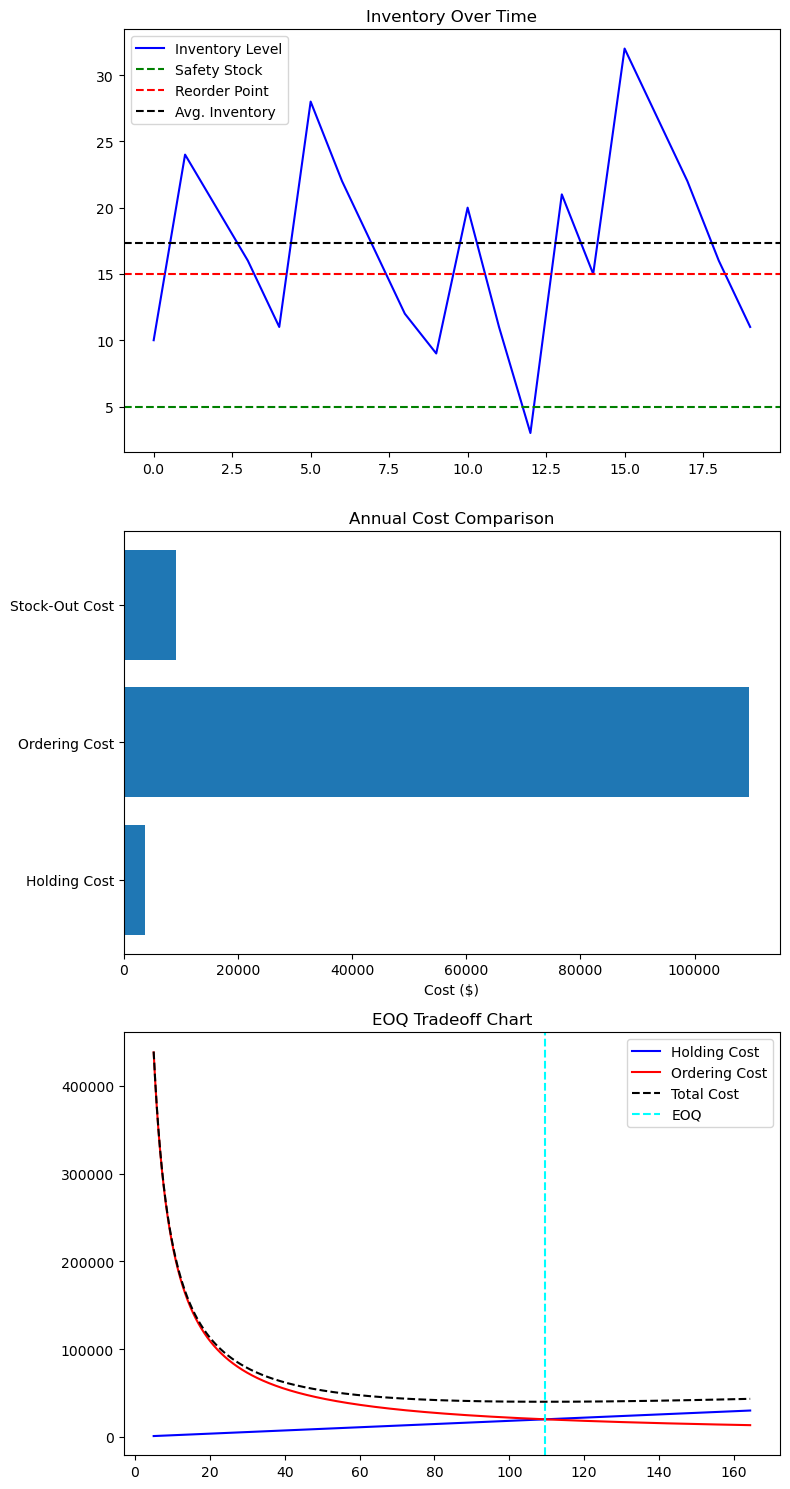

In [9]:
# Visualization
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

axes[0].plot(range(simulation_days), inventory_levels, label="Inventory Level", color='blue')
axes[0].axhline(safety_stock, color='green', linestyle='--', label="Safety Stock")
axes[0].axhline(reorder_point, color='red', linestyle='--', label="Reorder Point")
axes[0].axhline(average_inventory, color='black', linestyle='--', label="Avg. Inventory")
axes[0].set_title("Inventory Over Time")
axes[0].legend()

# Cost Comparison Bar Chart
axes[1].barh(["Holding Cost", "Ordering Cost", "Stock-Out Cost"], [holding_ann, ordering_ann, stock_out_ann])
axes[1].set_title("Annual Cost Comparison")
axes[1].set_xlabel("Cost ($)")

axes[2].plot(quantity, holding_cost_eoq, label="Holding Cost", color='blue')
axes[2].plot(quantity, ordering_cost_eoq, label="Ordering Cost", color='red')
axes[2].plot(quantity, total_cost_eoq, label="Total Cost", color='black', linestyle='dashed')
axes[2].axvline(eoq, color='cyan', linestyle='--', label="EOQ")
axes[2].set_title("EOQ Tradeoff Chart")
axes[2].legend()

plt.tight_layout()

fig.show()